# Homework2 Image Classification Inference Option

For this assigment, I chose to run inference on pre-trained models using PyTorch directly, with TorchScript, and in OpenVino. This code must be run on Linux, as neither TorchScript nor OpenVimo runs on Windows with this code. 

In [1]:
# Here are the packages that need to be installed in the environment.

# %pip install torch
# %pip install torchvision
# %pip install albumentations
# %pip install onnx
# %pip install opencv-python
# %pip install ipywidgets
# %pip install datasets
# %pip install seaborn

In [2]:
# Log into Hugging Face to get the ImageNet dataset if needed.

# from huggingface_hub import login
# login()

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import time
from torchvision.models import ResNet50_Weights, MobileNet_V2_Weights
import openvino.torch
import datasets

In [4]:
torch.manual_seed(1234)

In [5]:
# Define image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# Function to perform inference with a model on a single image
def inference(model, image: Image):
    image_tensor = preprocess(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    _, predicted_class = torch.max(probabilities, 0)
    return predicted_class.item()

In [7]:
# Function to test accuracy on a set of images
def test_model(model):
    correct = 0
    total = 0

    # load in the models so loading the model does not effect the timer
    for item in imagenet_validation:
        inference(model, item['image'])
        break 

    start_time = time.time()
    with torch.no_grad():
        for item in imagenet_head:
            if item['image'].mode == 'L':
                continue
            predicted_class = inference(model, item['image'])
            if predicted_class == item['label']:
                correct += 1
            total += 1
    end_time = time.time()
    inference_time = end_time - start_time
    return correct, total, inference_time

In [8]:
imagenet_validation = datasets.load_dataset("imagenet-1k", split="validation", streaming=True, trust_remote_code=True)
imagenet_head = imagenet_validation.take(400)

# list(imagenet_head)

In [9]:
# Load pretrained ResNet50 model
r50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Convert the model into TorchScript
r_50_torch_script = torch.jit.script(r50)
r_50_openvino = torch.compile(r50, backend='openvino')

# Set the models to evaluation mode
r50.eval()
r_50_torch_script.eval()
r_50_openvino.eval()

OptimizedModule(
  (_orig_mod): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [10]:
# Test accuracy and inference time of both models
correct_r50, total_r50, inference_time_r50 = test_model(r50)
correct_r_50_torch_script, total_r_50_torch_script, inference_time_r_50_torch_script = test_model(r_50_torch_script)
correct_r_50_openvino, total_r_50_openvino, inference_time_r_50_openvino = test_model(r_50_openvino)

print("Accuracies:")
print("Accuracy of ResNet50 model:", correct_r50 / total_r50)
print("Accuracy of TorchScript ResNet50 model:", correct_r_50_torch_script / total_r_50_torch_script)
print("Accuracy of OpenVino ResNet50 model:", correct_r_50_openvino / total_r_50_openvino)

print("Inference Times:")
print("Inference time of ResNet50 model:", inference_time_r50)
print("Inference time of TorchScript ResNet50 model:", inference_time_r_50_torch_script)
print("Inference time of OpenVino ResNet50 model:", inference_time_r_50_openvino)

Accuracies:
Accuracy of ResNet50 model: 0.8097686375321337
Accuracy of TorchScript ResNet50 model: 0.8097686375321337
Accuracy of OpenVino ResNet50 model: 0.8097686375321337
Inference Times:
Inference time of ResNet50 model: 37.979233741760254
Inference time of TorchScript ResNet50 model: 32.718854665756226
Inference time of OpenVino ResNet50 model: 22.966297388076782


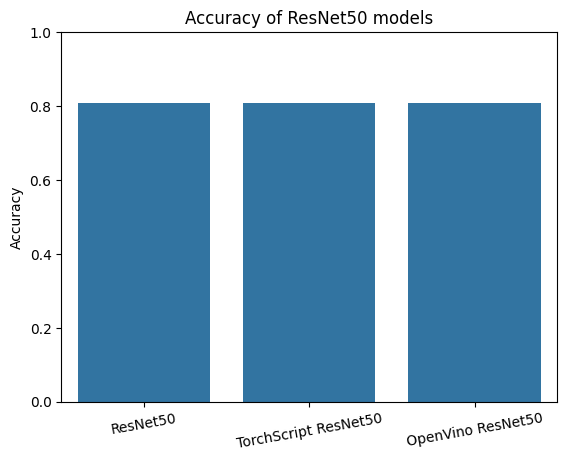

In [11]:
# Chart the Accuracy results in seaborn

import matplotlib.pyplot as plt
import seaborn as sns

accuracies = [correct_r50 / total_r50, correct_r_50_torch_script / total_r_50_torch_script, correct_r_50_openvino / total_r_50_openvino]
r50_models = ['ResNet50', 'TorchScript ResNet50', 'OpenVino ResNet50']

sns.barplot(x=r50_models, y=accuracies)

plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy of ResNet50 models')
plt.xticks(rotation=10)
plt.savefig('AccuracyofResNet50models.svg', format='svg')
plt.show()



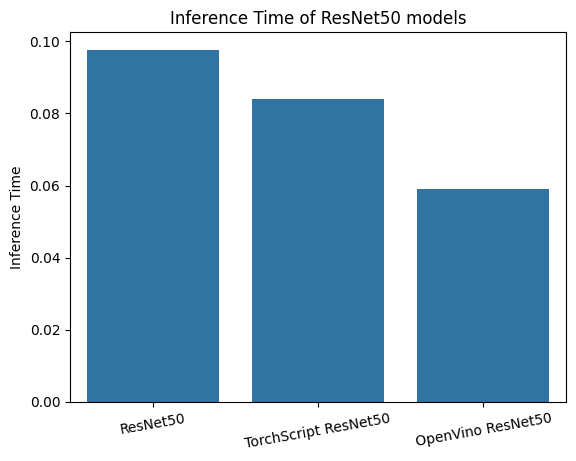

In [12]:
# Chart the average inference time in seaborn

r50_inference_times = [inference_time_r50 / total_r50, inference_time_r_50_torch_script / 
                   total_r_50_torch_script, inference_time_r_50_openvino /  total_r_50_openvino]

sns.barplot(x=r50_models, y=r50_inference_times)
plt.ylabel('Inference Time')
plt.title('Inference Time of ResNet50 models')
plt.xticks(rotation=10)
plt.savefig('InferenceTimeofResNet50models.svg', format='svg')
plt.show()

In [13]:
# Load pretrained ResNet50 model
mn2 = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)


# Convert the model into TorchScript
mn2_torch_script = torch.jit.script(mn2)
mn2_openvino = torch.compile(mn2, backend='openvino')

# Set the models to evaluation mode
mn2.eval()
mn2_torch_script.eval()
mn2_openvino.eval()

OptimizedModule(
  (_orig_mod): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_s

In [14]:
# Test accuracy and inference time of both models
correct_mn2, total_mn2, inference_time_mn2 = test_model(mn2)
correct_mn2_torch_script, total_mn2_torch_script, inference_time_mn2_torch_script = test_model(mn2_torch_script)
correct_mn2_openvino, total_mn2_openvino, inference_time_mn2_openvino = test_model(mn2_openvino)

print("Accuracies:")
print("Accuracy of MobileNet V2 model:", correct_mn2 / total_mn2)
print("Accuracy of TorchScript MobileNet V2 model:", correct_mn2_torch_script / total_mn2_torch_script)
print("Accuracy of OpenVino MobileNet V2 model:", correct_mn2_openvino / total_mn2_openvino)

print("Inference Times:")
print("Inference time of MobileNet V2 model:", inference_time_mn2)
print("Inference time of TorchScript MobileNet V2 model:", inference_time_mn2_torch_script)
print("Inference time of OpenVino MobileNet V2 model:", inference_time_mn2_openvino)

Accuracies:
Accuracy of MobileNet V2 model: 0.7480719794344473
Accuracy of TorchScript MobileNet V2 model: 0.7480719794344473
Accuracy of OpenVino MobileNet V2 model: 0.7480719794344473
Inference Times:
Inference time of MobileNet V2 model: 16.82914686203003
Inference time of TorchScript MobileNet V2 model: 15.381639957427979
Inference time of OpenVino MobileNet V2 model: 12.271672248840332


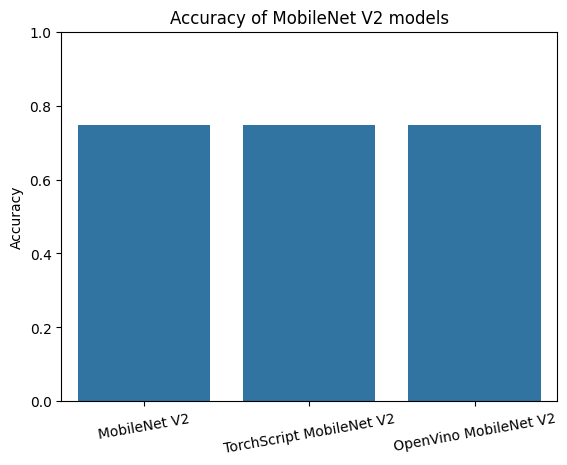

In [15]:
# Chart the Accuracy results in seaborn

import matplotlib.pyplot as plt
import seaborn as sns

accuracies = [correct_mn2 / total_mn2, correct_mn2_torch_script / total_mn2_torch_script, correct_mn2_openvino / total_mn2_openvino]
mn2_models = ['MobileNet V2', 'TorchScript MobileNet V2', 'OpenVino MobileNet V2']

sns.barplot(x=mn2_models, y=accuracies)

plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy of MobileNet V2 models')
plt.xticks(rotation=10)
plt.savefig('AccuracyofMobileNetV2models.svg', format='svg')
plt.show()

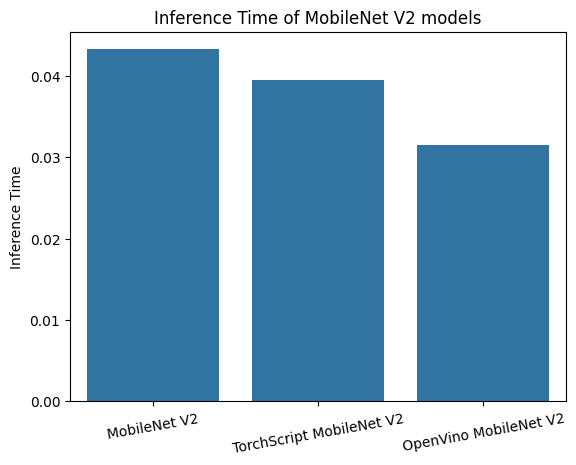

In [16]:
# Chart the average inference time in seaborn

mn2_inference_times = [inference_time_mn2 / total_mn2, inference_time_mn2_torch_script / 
                   total_mn2_torch_script, inference_time_mn2_openvino /  total_mn2_openvino]

sns.barplot(x=mn2_models, y=mn2_inference_times)
plt.ylabel('Inference Time')
plt.title('Inference Time of MobileNet V2 models')
plt.xticks(rotation=10)
plt.savefig('InferenceTimeofMobileNetV2models.svg', format='svg')
plt.show()

In [17]:
base_time = inference_time_r50 / total_r50
openvimo_time = inference_time_r_50_openvino / total_r_50_openvino

# find how much faster the OpenVino optimization is in comparison to the base model in percentage
percentage = ((base_time - openvimo_time) / base_time) * 100
print(f'The OpenVino optimization is {percentage}% faster than the base model')

The OpenVino optimization is 39.52932925335964% faster than the base model


In [18]:
base_time = inference_time_r50 / total_r50
torch_script_time = inference_time_r_50_torch_script / total_r_50_torch_script

# find how much faster the TorchScript optimization is in comparison to the base model in percentage
percentage = ((base_time - torch_script_time) / base_time) * 100
print(f'The TorchScript optimization is {percentage}% faster than the base model')

The TorchScript optimization is 13.850671953446888% faster than the base model
